## Coal or Nuclear: What Type of Powerplant am I Looking At?
Uncovering the mystery behind the energy infrastructure being used in our backyard. 

This notebook stems from an idea I have that would enable any person to take a picture of any type of energy infrastructure, and have the tool tell them exactly what they're looking at. We will build one small snippet of this idea. 

Driving along the highway in Germany, it's tough to tell if I'm looking at a coal power plant or a nuclear one. Considering I work in the energy industry, I feel like this is something I should know. Both types of power plants will be phased out by Germany in the coming years (nuclear - 2022, coal - 2038), but in the meantime - let's build a tool to help us figure out which one of the two we're looking at. 

The purpose of this idea is to help the general population better understand how their energy needs are being met.

### 1. Project Setup

Import necessary packages. For this workbook, we will employ fastai.

In [1]:
#automatically reload any edits to libraries
%reload_ext autoreload
%autoreload 2

#display all charts directly in notebook
%matplotlib inline

In [13]:
#import fastai, numpy packages
from fastai.vision import *
import numpy as np

### 2. Create the Dataset

To build the dataset, we need pictures of both coal and nuclear power plants. We will build our dataset using images found on Google. For the first pass at this problem, we won't discriminate our downloads based on geographic location - but recognize that in certain parts of the world a two power stations using the same fuel could look different. Downloading images based on geographic region could be stage two of this model!

Both plants fall into the category of **thermal power plants** where a fuel is used to boil water and create steam. The steam spins a turbine, in turn, generating electricity. 




#### Retrieve URL List from Google

Very specific Google search to limit future dataset cleaning
1. *coal power plant germany -nuclear -solar -wind -thermal -biomass -diagram -chart -schematic -process*
    - saved as **coal_urls.csv**
    
    
2. *nuclear power plant germany -coal -solar -wind -thermal -biomass -diagram -chart -schematic -process*
    - saved as **nuclear_urls.csv**

In [3]:
#define folder name where we will download the future coal plant images 
folder = 'coal_plant'

#define file object with same name as URLs file we just saved from above
file = 'coal_urls.csv'

In [4]:
#repeat for each subsequent category
folder = 'nuclear_plant'
file = 'nuclear_urls.csv'

In [8]:
#set path to directory
path = Path('energy_infrastructure')

#set destination of folder
dest = path/folder

In [ ]:
#create the folder for each type within the energy_infrastructure directory
#repeat for each type by re-running 'folder' code above
dest.mkdir(parents=True, exist_ok=True)

In [9]:
path.ls()

[PosixPath('energy_infrastructure/coal_plant'),
 PosixPath('energy_infrastructure/models'),
 PosixPath('energy_infrastructure/nuclear_plant'),
 PosixPath('energy_infrastructure/coal_urls.csv'),
 PosixPath('energy_infrastructure/nuclear_urls.csv')]

Finally, upload .csv files downloaded from Google using the Jupyter notebook to the home directory.

#### Download the Images
The URLs for each type of images reside in their respective .csv files. We now need to use those URLs to download the images. To do so, we call the fastai function *download_images*.

In [27]:
#using image URLs in each .csv file, download images from Google
#repeat for each category, by updating the parameters (above) that are passed to the function

download_images(path/file, dest, max_pics=250)

In [28]:
#define classes for step below
classes = ['coal_plant', 'nuclear_plant']

In [29]:
#remove all images that can't be opened by calling the fastai function verify_images
#also resizes images to limit length/width to specified size
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500 )

#### View the Images

In [14]:
#always returns the same set of random numbers used to initialize the model (so you can reproduce your results)
#XX in .seed(XX) refers to which set of random numbers you get, '42' was chosen at random!
np.random.seed(42)

#create data bunch by calling the fastai from_folder function
#training folder in home directory, validation set to 20% of dataset, using 4 CPUs
data = ImageDataBunch.from_folder(path,
                                  train=".",
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(),
                                  size=224,
                                  num_workers=4).normalize(imagenet_stats)

In [15]:
#show the different classes contained in our databunch
data.classes

['coal_plant', 'nuclear_plant']

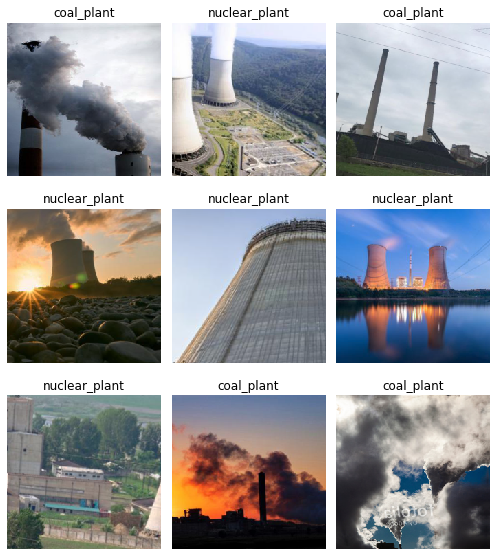

In [16]:
#display images
data.show_batch(rows=3, figsize=(7,8))

In [17]:
data.classes

['coal_plant', 'nuclear_plant']

In [18]:
#Print the following four items:
#1. Class Names
#2. Number of total Classes
#3. Size of training set
#4. Size of validation set
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['coal_plant', 'nuclear_plant'], 2, 376, 93)

### 3. Train the Model

In [19]:
#create learner object
thermalenergy = cnn_learner(data, models.resnet34, metrics=error_rate)

In [50]:
#train model
thermalenergy.fit_one_cycle(4)

In [51]:
#save the progress
thermalenergy.save('thermal_v1')

In [52]:
#train all the layers
thermalenergy.unfreeze()

In [53]:
#seek optimal learning rate
thermalenergy.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


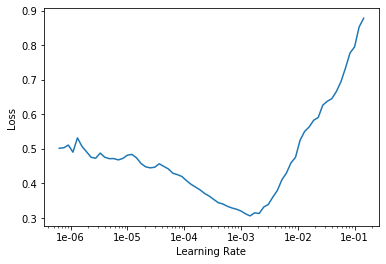

In [55]:
#let's find the best learning rate
thermalenergy.recorder.plot()

In [56]:
#retrain the model with dialed-in weights
thermalenergy.fit_one_cycle(4, max_lr=slice(2e-4, 8e-4))

In [58]:
#let's save this - great improvement over original results
thermalenergy.save('thermal_v2')

### 4. Intrepret the Model

In [20]:
#load our most accurate model to date
thermalenergy.load('thermal_v2')

Learner(data=ImageDataBunch;

Train: LabelList (376 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
coal_plant,coal_plant,coal_plant,coal_plant,coal_plant
Path: energy_infrastructure;

Valid: LabelList (93 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
coal_plant,coal_plant,coal_plant,nuclear_plant,nuclear_plant
Path: energy_infrastructure;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

In [21]:
#build interpretation object
interp = ClassificationInterpretation.from_learner(thermalenergy)

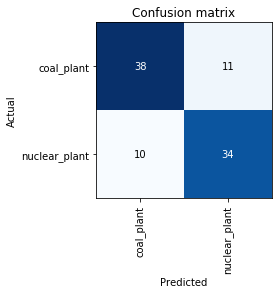

In [22]:
#identify where the majority of the errors are coming from
interp.plot_confusion_matrix()

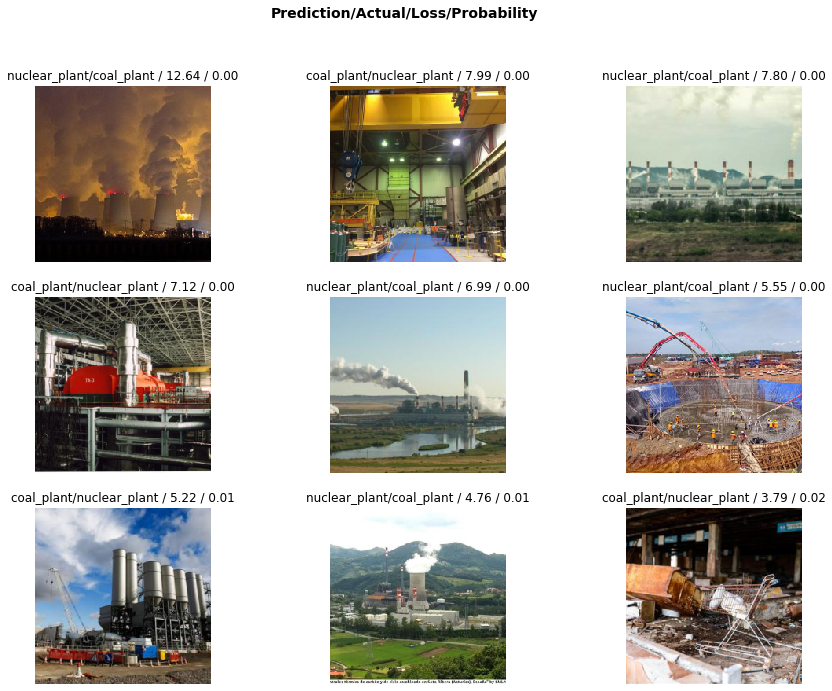

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

### 5. Clean-up the Data
Given this dataset was downloaded right from Google with limited quality control, we should delete images that don't belong. This should improve the accuracy of our model.

Using the `ImageCleaner` widget from `fastai.widgets` we can remove the 'dirty' photos from our dataset.

In [30]:
from fastai.widgets import *

Process to use ImageCleaner:

1. Create a new data bunch without the training/test split.
2. Define new learner object, then load our current weights 'thermal_v2'.
3. Get the file paths of our top losses using `.from_toplosses`
4. Feed the indexes and corresponding dataset to `Image Cleaner`
5. `Image Cleaner` will not delete images from the original dataset, rather create a new csv file that you can use to create a new ImageDataBunch.

In [33]:
#create a new data bunch object, with no test/training split
data_ns = (ImageList.from_folder(path)
                .split_none()
                .label_from_folder()
                .transform(get_transforms(), size=224)
                .databunch()
               )

In [42]:
#create new leaner object using new data bunch
thermlearn_v1 = cnn_learner(data_ns, models.resnet34, metrics=error_rate)

#load weights from previously trained model
thermlearn_v1.load('thermal_v2')

Learner(data=ImageDataBunch;

Train: LabelList (469 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
coal_plant,coal_plant,coal_plant,coal_plant,coal_plant
Path: energy_infrastructure;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: energy_infrastructure;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, ke

In [43]:
#delete images that aren't coal or nuclear plants
#return the file paths (ds) and indexes (idxs) of top loss images
ds, idxs = DatasetFormatter().from_toplosses(thermlearn_v1)

In [45]:
#run the image cleaner, returns a file called cleaned.csv
ImageCleaner(ds, idxs, path)

'No images to show :)'

In [46]:
#delete potential duplicate images
#return the file paths (ds) and indexes (idxs) of potential duplicate images
ds, idxs = DatasetFormatter().from_similars(thermlearn_v1)

Getting activations...


Computing similarities...


In [47]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

### 6. Train New Model Using Newly Cleaned Dataset
We've combed through the data to eliminate images that don't belong in the dataset. We did this because we did a bulk download from Google based on a search result, and there is generally a bit of noise among the images. We will retrain the model to see if we've made any gain on accurately predicting coal vs. nuclear power plants.

In [48]:
#let's have a look at the cleaned.csv file to see how it's organized
pd.read_csv(path/'cleaned.csv').head()

name       label
0  coal_plant/00000084.jpg  coal_plant
1  coal_plant/00000157.jpg  coal_plant
2  coal_plant/00000238.jpg  coal_plant
3  coal_plant/00000223.jpg  coal_plant
4  coal_plant/00000024.jpg  coal_plant

In [59]:
#create new image data bunch using cleaned.csv
data_clean = ImageDataBunch.from_csv(path, ds_tfms=get_transforms(), size=224);

In [78]:
#check the size of the cleaned dataset
data_clean.classes, data.c, len(data_clean.train_ds), len(data_clean.valid_ds)

(['coal_plant', 'nuclear_plant'], 2, 357, 89)

The original dataset contained **469** images, the cleaned dataset now includes **446** images.

We deleted 23 images using ImageCleaner.

In [60]:
#create a new learner object with the newly cleaned data
thermlearn_v2 = cnn_learner(data_clean, models.resnet34, metrics=error_rate)

In [61]:
thermlearn_v2.fit_one_cycle(4)

In [62]:
thermlearn_v2.save('thermal_v3')

In [64]:
thermlearn_v2.unfreeze()

In [65]:
thermlearn_v2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


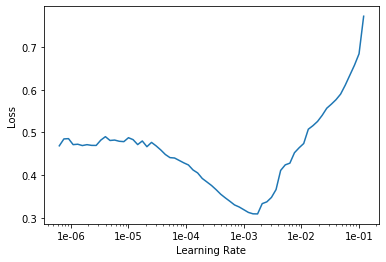

In [67]:
thermlearn_v2.recorder.plot()

In [72]:
thermlearn_v2.fit_one_cycle(4, max_lr=slice(2e-4, 8e-4))

In [73]:
thermlearn_v2.save('thermal_v4')

After cleaning the data, we've improved our model accuracy from **77.4% to 80.9%** (error reduction of 15%!). Not a bad little jump considering we didn't add any new data, just got rid of a bit of bad data. This means that we should be able to correctly classify a coal or nuclear plant, 4 out of 5 times.

Let's have a quick look at where the model is stil getting hung up.

In [74]:
interp_v1 = ClassificationInterpretation.from_learner(thermlearn_v2)

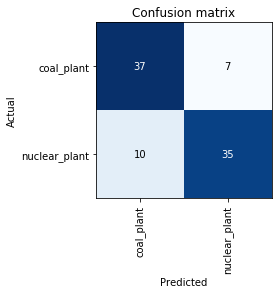

In [75]:
interp_v1.plot_confusion_matrix()

Compared to last time, the model got better at predicting nuclear plants. Almost no gain on coal plant prediction.

### 7. Put Model Into Production
We've combed through the data to eliminate images that don't belong in the dataset. We did this because we did a bulk download from Google based on a search result, and there is generally a bit of noise among the images. We will retrain the model to see if we've made any gain on accurately predicting coal vs. nuclear power plants.

In [79]:
#export our leaner object (model)
#creates a file named export.pkl in the main directory
thermlearn_v2.export()

In [81]:
#for inteference (having the model predict things), we can test using a CPU
defaults.device = torch.device('cpu')

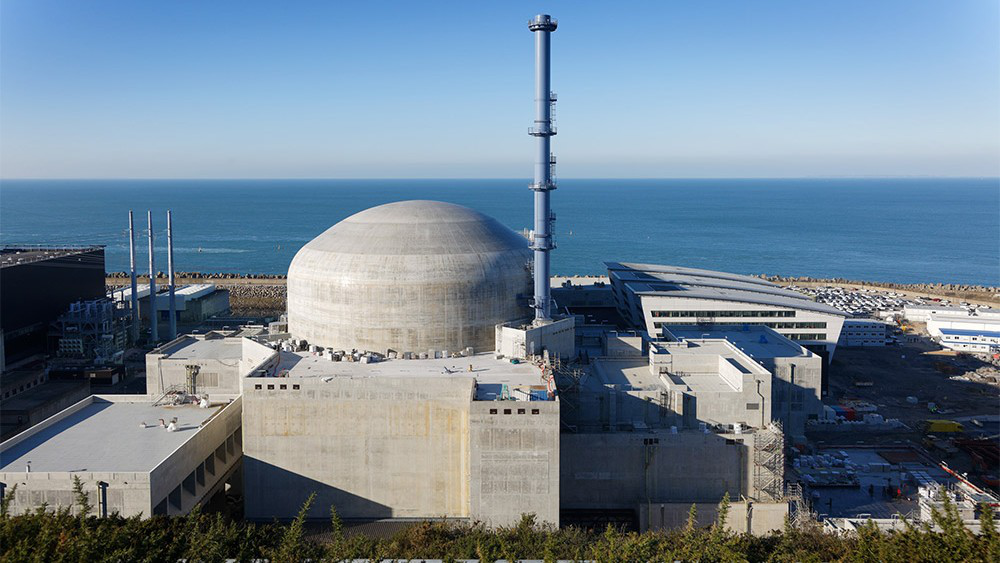

In [86]:
img_1 = open_image(path/'Nuclear_Test.jpg')
img_1

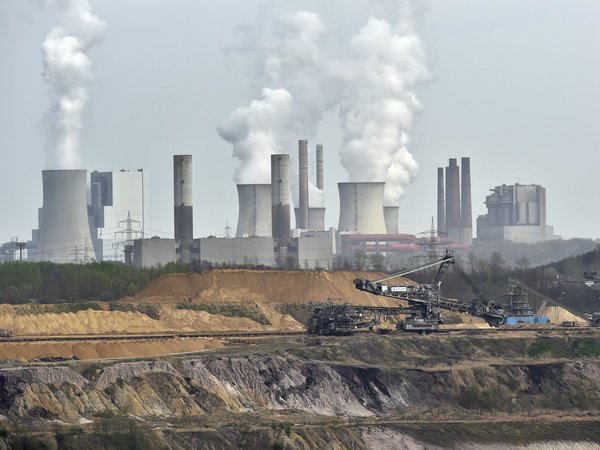

In [87]:
img_2 = open_image(path/'Coal_Test.jpg')
img_2

In [88]:
learn_final = load_learner(path)

In [98]:
pred_class, pred_idx, outputs = learn_final.predict(img_1)
pred_class, outputs

(Category nuclear_plant, tensor([2.7040e-13, 1.0000e+00]))

In [99]:
pred_class, pred_idx, outputs = learn_final.predict(img_2)
pred_class, outputs

(Category coal_plant, tensor([9.9998e-01, 1.7818e-05]))

Two for two! Time to quit while I'm ahead.

Ah, those were too easy. Let's try something a little tougher.

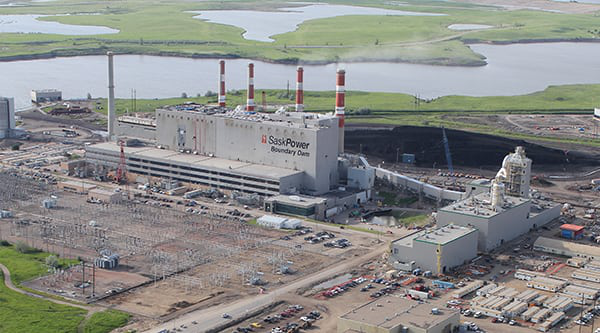

In [102]:
img_3 = open_image(path/'Coal_Test1.jpg')
img_3

In [104]:
pred_class, pred_idx, outputs = learn_final.predict(img_3)
pred_class, outputs

(Category nuclear_plant, tensor([0.1273, 0.8727]))

Interesting. This is actually a coal plant in SE Saskatchewan. It's an important one, as it's leading the charge in carbon capture technology.

1. Burn coal to heat water into steam.
2. The steam turns big turbines, which produce electricity.
3. That electricity is consumed by the residents of Saskatchewan.
4. The resulting CO2 emissions from burning the coal are captured and used in a neighbouring oil field to enhance oil recovery (as opposed to drilling new wells).

Let's feed the model with a picture of something that's not a coal or nuclear powerplant.

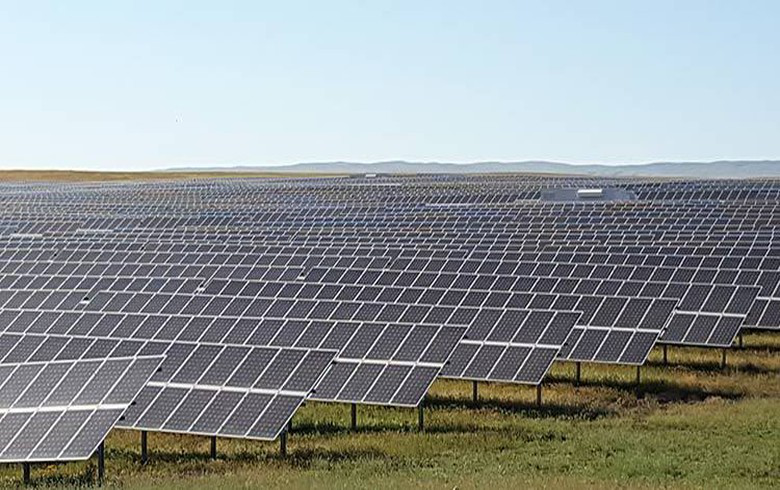

In [108]:
img_4 = open_image(path/'Solar_Panel.jpg')
img_4

In [109]:
pred_class, pred_idx, outputs = learn_final.predict(img_4)
pred_class, outputs

(Category coal_plant, tensor([0.8478, 0.1522]))

Intersting. When you feed a non coal or nuclear plant image, the model will still return a prediction. 

**I wonder how you build in a category that is "none of the above"?**

Well, we'll have to save that for later.

~Jordan